# WiDS Datathon 2026 - Exploratory Data Analysis

**Workshop Session 1: Understanding the Data**

This notebook explores the wildfire prediction dataset through visualizations and statistical analysis.

## Learning Objectives
1. Understand the survival analysis problem structure
2. Explore target variable distributions
3. Analyze feature patterns and relationships
4. Identify data quality issues
5. Discover insights for modeling

## 1. Setup and Data Loading

In [77]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

print("✓ Libraries imported successfully!")

✓ Libraries imported successfully!


In [78]:
# Load data
train_df = pd.read_csv('../WiDSWorldWide_GlobalDathon26/train.csv')
test_df = pd.read_csv('../WiDSWorldWide_GlobalDathon26/test.csv')
metadata_df = pd.read_csv('../WiDSWorldWide_GlobalDathon26/metaData.csv')

print(f"Training data: {train_df.shape[0]} rows × {train_df.shape[1]} columns")
print(f"Test data: {test_df.shape[0]} rows × {test_df.shape[1]} columns")
print(f"\n✓ Data loaded successfully!")

Training data: 221 rows × 37 columns
Test data: 95 rows × 35 columns

✓ Data loaded successfully!


## 📈 Automated Data Profiling

Generate comprehensive HTML reports using ydata-profiling for detailed data analysis.

In [79]:
# Check if profiling reports exist, generate if not
import os
from pathlib import Path

# Define report paths
train_profile_path = Path('train_data_profile.html')
test_profile_path = Path('test_data_profile.html')
comparison_profile_path = Path('train_test_comparison.html')

# Check if reports exist
reports_exist = all([
    train_profile_path.exists(),
    test_profile_path.exists(),
    comparison_profile_path.exists()
])

if reports_exist:
    print("✓ Data profiling reports already exist:")
    print(f"  - {train_profile_path}")
    print(f"  - {test_profile_path}")
    print(f"  - {comparison_profile_path}")
    print("\nOpen these HTML files in a web browser to view interactive reports.")
else:
    print("⚠️  Profiling reports not found. Generating now...")
    print("This will take 3-5 minutes. Please wait...\n")
    
    try:
        from ydata_profiling import ProfileReport
        import warnings
        warnings.filterwarnings('ignore')
        
        # Generate training data profile
        if not train_profile_path.exists():
            print("📊 Generating training data profile...")
            train_profile = ProfileReport(
                train_df,
                title="WiDS Datathon 2026 - Training Data Profile",
                explorative=True,
                minimal=False,
                correlations={
                    "pearson": {"calculate": True},
                    "spearman": {"calculate": True},
                    "kendall": {"calculate": False},
                    "phi_k": {"calculate": False},
                    "cramers": {"calculate": False},
                },
            )
            train_profile.to_file(str(train_profile_path))
            print(f"  ✓ Saved: {train_profile_path}")
        
        # Generate test data profile
        if not test_profile_path.exists():
            print("📊 Generating test data profile...")
            test_profile = ProfileReport(
                test_df,
                title="WiDS Datathon 2026 - Test Data Profile",
                explorative=True,
                minimal=False,
                correlations={
                    "pearson": {"calculate": True},
                    "spearman": {"calculate": True},
                    "kendall": {"calculate": False},
                    "phi_k": {"calculate": False},
                    "cramers": {"calculate": False},
                },
            )
            test_profile.to_file(str(test_profile_path))
            print(f"  ✓ Saved: {test_profile_path}")
        
        # Generate comparison report
        if not comparison_profile_path.exists():
            print("📊 Generating train vs test comparison...")
            comparison_report = train_profile.compare(test_profile)
            comparison_report.to_file(str(comparison_profile_path))
            print(f"  ✓ Saved: {comparison_profile_path}")
        
        print("\n✅ All profiling reports generated successfully!")
        print("Open the HTML files in a web browser to explore the data.")
        
    except ImportError:
        print("❌ ydata-profiling not installed.")
        print("Install with: pip install ydata-profiling")
    except Exception as e:
        print(f"❌ Error generating profiles: {e}")
        print("You can continue with the EDA without the profiling reports.")

✓ Data profiling reports already exist:
  - train_data_profile.html
  - test_data_profile.html
  - train_test_comparison.html

Open these HTML files in a web browser to view interactive reports.


## The Challenge

**What you predict:** Four probabilities for each fire. Each probability represents the likelihood that the fire comes within 5 km of an evacuation zone centroid by the horizon: 
**prob_12h**
**prob_24h**
**prob_48h**
**prob_72h**


### 🎯 Target Variables
- `event`: Binary outcome (1 = fire hit evacuation zone within 72h, 0 = censored)
- `time_to_hit_hours`: Time until fire reached zone (for event=1) or last observed time for censored events (event=0)

---
## 📊 Understanding the Features

The dataset contains **34 features** organized into 6 categories that capture different aspects of wildfire behavior.

**Important:** Features computed strictly from the first five hours after initial perimeter detection.

### 1. 🕐 Temporal Coverage (3 features)
**Data quality indicators** - How frequently the fire was monitored
- `num_perimeters_0_5h`: Number of perimeter observations (1-17)
- `dt_first_last_0_5h`: Time span between first and last observation (0-5 hours)
- `low_temporal_resolution_0_5h`: Flag for poor data quality (1 = only 1 perimeter or <0.5h span)

**Key insight**: 72% of fires have only a single perimeter observation, limiting growth/movement calculations.

---

### 2. 🔥 Growth Features (10 features)
**Fire expansion metrics** - How aggressively the fire is growing
- `area_first_ha`: Initial fire size (hectares)
- `area_growth_abs_0_5h`: Absolute area gained (hectares)
- `area_growth_rel_0_5h`: Relative growth (% increase)
- `area_growth_rate_ha_per_h`: Expansion speed (ha/hour)
- `radial_growth_m`: Radius increase (meters)
- `radial_growth_rate_m_per_h`: Perimeter expansion speed (m/hour)
- Plus log-transformed versions for better model performance

**Key insight**: Growth rates are critical for predicting near-term threats. Fast-growing fires are more dangerous.

---

### 3. 🎯 Centroid Kinematics (5 features)
**Fire movement tracking** - Where the fire's center is moving
- `centroid_displacement_m`: Total distance fire center moved (meters)
- `centroid_speed_m_per_h`: Speed of fire movement (m/hour)
- `spread_bearing_deg`: Direction of movement (0-360°)
- `spread_bearing_sin/cos`: Circular encoding of direction (ML-friendly)

**Key insight**: Fast-moving fires are harder to contain. Direction matters when combined with evacuation zone locations.

---

### 4. 📏 Distance Features (9 features)
**Proximity to evacuation zones** - The heart of the prediction problem
- `dist_min_ci_0_5h`: **CRITICAL** - Minimum distance to nearest zone (meters)
- `dist_std_ci_0_5h`: Variability in distances to different zones
- `dist_change_ci_0_5h`: Change in distance over 5 hours
- `dist_slope_ci_0_5h`: Rate of distance change (m/hour)
- `closing_speed_m_per_h`: Speed at which fire is closing distance
- `dist_accel_m_per_h2`: Acceleration in distance change
- `dist_fit_r2_0_5h`: How predictable the distance trend is (0-1)

**Key insight**: There's **perfect separation at 5km** - ALL hits are ≤5km, ALL censored fires are >5km. While distance features will be likely be among our strongest predictors, we need to be cautious not to overfit.

---

### 5. 🧭 Directionality Features (4 features)
**Vector analysis** - Is the fire moving TOWARD or AWAY from zones?
- `alignment_cos`: Cosine of angle between fire movement and zone direction
  - **+1.0** = Moving directly TOWARD zones ⚠️
  - **-1.0** = Moving directly AWAY from zones ✓
- `alignment_abs`: Magnitude of alignment (0-1)
- `along_track_speed`: Speed component toward/away from zones (m/hour)
- `cross_track_component`: Sideways drift component (m/hour)

**Key insight**: Fires moving toward zones with positive `along_track_speed` are immediate threats. However, centroid movement can be misleading - fire perimeter can reach zones even if centroid moves away.

---

### 6. 📅 Temporal Metadata (3 features)
**When the fire started** - Seasonal and diurnal patterns
- `event_start_hour`: Hour of day (0-23)
- `event_start_dayofweek`: Day of week (0=Monday, 6=Sunday)
- `event_start_month`: Month (1-12)

**Key insight**: Peak fire season (June-September) and afternoon fires (14-18h) tend to spread faster due to environmental conditions.

---

### ⏰ Understanding the Timeline

**Critical Temporal Structure** - Understanding when things happen:

```
t0 (fire start)
    |
    |<--- Feature Measurement Window (5 hours) --->|
    |                                              |
    |     dist_min_ci_0_5h measured here          t0+5h (prediction time)
    |                                              |
    |                                              |<--- time_to_hit_hours --->| Event!
    |                                              |                            |
    0h                                            5h                    5h + time_to_hit
```

**Key Points:**
- **t0**: Fire ignition/detection time
- **t0 to t0+5h**: Feature measurement window (ALL features measured during first 5 hours)
- **t0+5h**: End of feature window (our prediction time)
- **time_to_hit_hours**: Time FROM t0+5h UNTIL the event occurs

---

### ⚠️ Important Data Considerations

1. **Single Perimeter Fires (72%)**: Most fires have only 1 observation, so growth and movement features are 0.0
2. **Feature Redundancy**: Some features measure the same thing differently (e.g., `dist_change` vs `projected_advance`)
3. **Perfect Separation**: The 5km threshold creates perfect separation - discovered in Distance Features section below
4. **Centroid Limitations**: Centroid-based features don't capture asymmetric fire growth

---

## 🎯 Competition Evaluation Metrics

Understanding how models will be evaluated is crucial for the WiDS Datathon. The competition uses a **hybrid scoring system** that balances two complementary aspects of model performance.

### 📊 Final Score Formula

```
Final Score = 0.3 × C-index + 0.7 × (1 - Weighted Brier Score)
```

**Range**: 0 to 1 (higher is better)

---

### 1️⃣ C-index (Concordance Index) - 30% of Score

**What it measures**: Can your model correctly **rank** fires by threat level and timing?

**How it works** - C-index evaluates **comparable pairs** of fires:

1. **Event vs Event**: If both fires hit, did you predict higher probability for the fire that hit EARLIER?
   - Fire A hits at 10h, Fire B hits at 30h
   - ✅ Correct if: P(A) > P(B) at any time horizon


2. **Event vs Censored**: Did you predict higher probability for the fire that actually hit?
   - Fire A hits at 20h, Fire B censored at 72h (never hit)
   - ✅ Correct if: P(A) > P(B)


3. **Censored vs Censored**: NOT comparable (we don't know which would have hit first)
   - These pairs are excluded from C-index calculation


**Formula**: C-index = (# correctly ordered pairs) / (# comparable pairs)

**Interpretation**:
- **0.5** = Random guessing (coin flip)
- **0.7** = Decent discrimination
- **0.8** = Good discrimination
- **0.9** = Excellent discrimination
- **1.0** = Perfect ranking

**Why it matters**:
- ✅ Ensures model can identify which fires are MORE threatening
- ✅ Critical for prioritization and resource allocation
- ✅ Less sensitive to calibration issues
- ⚠️ Doesn't measure probability accuracy (only relative ordering)

---

### 2️⃣ Weighted Brier Score - 70% of Score!

**What it measures**: Are your predicted **probabilities accurate** at multiple time horizons?

**How it works**:
```python
Brier Score = (predicted_probability - actual_outcome)^2
```

**Evaluated at 3 time horizons** (not 4!):
- **24 hours** (30% weight)
- **48 hours** (40% weight) ⭐ Highest weighted!
- **72 hours** (30% weight)

**Final Score**: `0.3 × Brier@24h + 0.4 × Brier@48h + 0.3 × Brier@72h`

**Why 48h is weighted highest**:
- 24-48 hours is the **strongest operational value zone**
- Balances actionable lead time with decision urgency
- 72h included for extended planning but less operationally immediate

**Censor-aware evaluation** - How outcomes are determined at each horizon H:
- **Hits before H**: actual_outcome = 1 (fire hit by this time)
- **Hits after H**: actual_outcome = 0 (fire will hit, but not yet)
- **Censored at/after H**: actual_outcome = 0 (fire didn't hit by this time)
- **Censored before H**: EXCLUDED (we don't know what would have happened)

**Training Data Breakdown** (221 fires: 69 hits, 152 censored):
- **24h**: 196 fires evaluated (63 outcome=1, 133 outcome=0) | 25 excluded
- **48h**: 166 fires evaluated (66 outcome=1, 100 outcome=0) | 55 excluded
- **72h**: 69 fires evaluated (69 outcome=1, 0 outcome=0) | 152 excluded ⚠️

**Critical insight**: 72h horizon evaluates ONLY fires that hit - it measures temporal ordering (when fires hit), not discrimination (hit vs non-hit).

**Interpretation**:
- **0.0** = Perfect calibration (predictions match reality)
- **0.25** = Random predictions (for binary outcome)
- **1.0** = Worst possible (always wrong)

**Why it matters (heavily weighted at 70%!)**:
- ✅ Ensures probabilities are **meaningful** for decision-making
- ✅ Critical for evacuation timing at operationally relevant horizons
- ✅ Requires both discrimination AND calibration
- 📌 **Well-calibrated**: If model says 30% probability, ~30% of those fires actually hit

---

### ⚡ Monotonicity Constraint (Required!)

Your predictions MUST satisfy:
```
P(hit by 12h) ≤ P(hit by 24h) ≤ P(hit by 48h) ≤ P(hit by 72h)
```

**Why**: Longer time windows = more opportunity for fire to reach zones. Probabilities must be non-decreasing.

**Implementation strategies**:
1. **Post-processing**: Sort predictions after model output
2. **Constrained models**: Build monotonicity into model architecture
3. **Cumulative approach**: Model incremental probabilities

⚠️ **Violating monotonicity = submission will be rejected!**

---

### 🎓 Key Takeaways for Modeling

**Balance both metrics**:
- **C-index (30%)**: Focus on feature importance for discrimination
  - Distance features, growth rates, directionality
  - Relative rankings matter more than exact probabilities

- **Brier Score (70%)**: Focus on probability calibration
  - Avoid overconfidence or underconfidence
  - May need calibration layer (Platt scaling, isotonic regression)
  - Test predictions against actual outcomes

**Common pitfalls to avoid**:
1. ❌ High C-index but poor Brier → Model discriminates but probabilities are miscalibrated
2. ❌ Low C-index but good Brier → Probabilities calibrated but can't rank fires
3. ❌ Monotonicity violations → Automatic penalty

**Validation strategy**:
- Track both metrics separately during development
- Create calibration plots to check probability accuracy
- Always verify monotonicity in predictions
- Consider time-stratified cross-validation

---

Now let's explore the data! 🔍

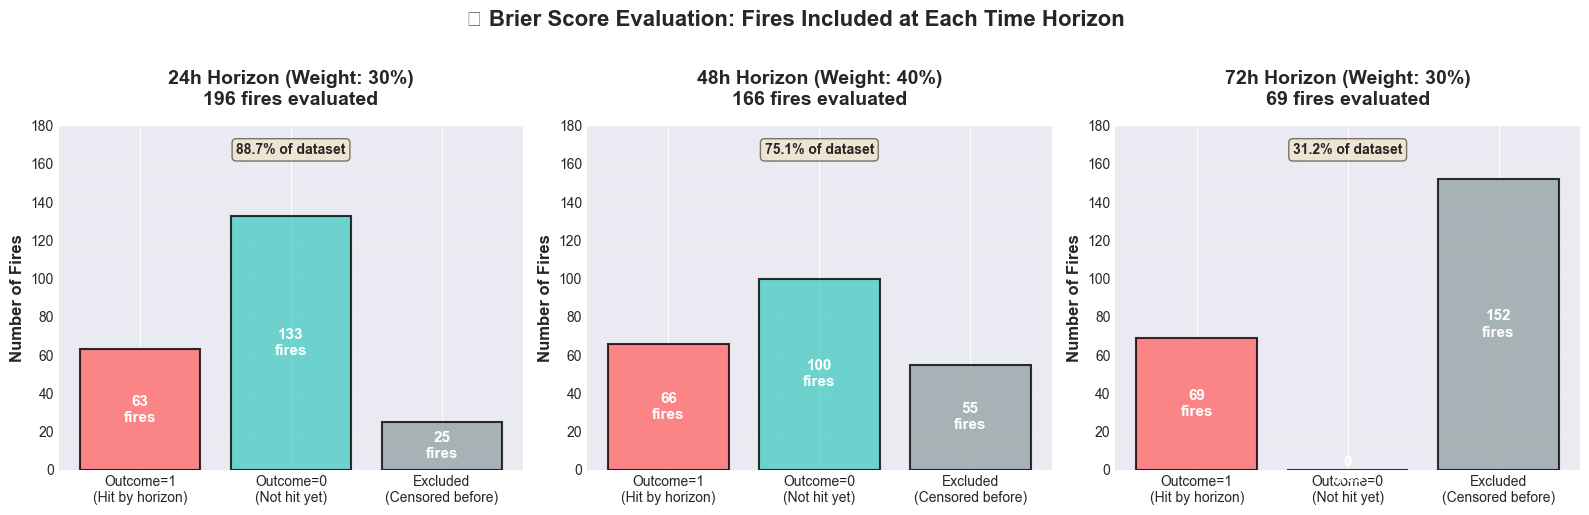


KEY INSIGHT: Evaluation Coverage Decreases with Longer Horizons

24h: 196/221 fires (88.7%)
48h: 166/221 fires (75.1%)
72h: 69/221 fires (31.2%) ⚠️ ONLY HITS!

⚡ The 72h horizon measures WHEN fires hit, not IF they hit.
   This is why 48h gets the highest weight (40%) - best balance of coverage and discrimination.


In [76]:
# Visualize how many fires are evaluated at each time horizon
import matplotlib.pyplot as plt
import numpy as np

# Calculate evaluation breakdown for each horizon
horizons = [24, 48, 72]
data = []

for h in horizons:
    hits_by_h = len(train_df[(train_df['event'] == 1) & (train_df['time_to_hit_hours'] <= h)])
    hits_after_h = len(train_df[(train_df['event'] == 1) & (train_df['time_to_hit_hours'] > h)])
    censored_after_h = len(train_df[(train_df['event'] == 0) & (train_df['time_to_hit_hours'] >= h)])
    censored_before_h = len(train_df[(train_df['event'] == 0) & (train_df['time_to_hit_hours'] < h)])
    
    data.append({
        'horizon': f'{h}h',
        'outcome_1': hits_by_h,
        'outcome_0': hits_after_h + censored_after_h,
        'excluded': censored_before_h
    })

# Create visualization
fig, axes = plt.subplots(1, 3, figsize=(16, 5))
colors = {'outcome_1': '#ff6b6b', 'outcome_0': '#4ecdc4', 'excluded': '#95a5a6'}
weights = [0.3, 0.4, 0.3]

for idx, (d, weight) in enumerate(zip(data, weights)):
    ax = axes[idx]
    
    # Create stacked bar
    categories = ['Outcome=1\n(Hit by horizon)', 'Outcome=0\n(Not hit yet)', 'Excluded\n(Censored before)']
    values = [d['outcome_1'], d['outcome_0'], d['excluded']]
    bar_colors = [colors['outcome_1'], colors['outcome_0'], colors['excluded']]
    
    bars = ax.bar(categories, values, color=bar_colors, edgecolor='black', linewidth=1.5, alpha=0.8)
    
    # Add value labels on bars
    for bar, val in zip(bars, values):
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height/2,
                f'{val}\nfires',
                ha='center', va='center', fontweight='bold', fontsize=11, color='white')
    
    # Styling
    total_evaluated = d['outcome_1'] + d['outcome_0']
    ax.set_title(f"{d['horizon']} Horizon (Weight: {weight*100:.0f}%)\n{total_evaluated} fires evaluated", 
                 fontsize=14, fontweight='bold', pad=15)
    ax.set_ylabel('Number of Fires', fontsize=12, fontweight='bold')
    ax.set_ylim(0, 180)
    ax.grid(axis='y', alpha=0.3, linestyle='--')
    ax.set_xticklabels(categories, fontsize=10)
    
    # Add percentage annotation
    pct_evaluated = 100 * total_evaluated / len(train_df)
    ax.text(0.5, 0.95, f'{pct_evaluated:.1f}% of dataset', 
            transform=ax.transAxes, ha='center', va='top',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5),
            fontsize=10, fontweight='bold')

plt.suptitle('🎯 Brier Score Evaluation: Fires Included at Each Time Horizon', 
             fontsize=16, fontweight='bold', y=1.02)
plt.tight_layout()
plt.show()

# Print summary
print("\n" + "="*80)
print("KEY INSIGHT: Evaluation Coverage Decreases with Longer Horizons")
print("="*80)
print(f"\n24h: {data[0]['outcome_1'] + data[0]['outcome_0']}/221 fires ({100*(data[0]['outcome_1'] + data[0]['outcome_0'])/221:.1f}%)")
print(f"48h: {data[1]['outcome_1'] + data[1]['outcome_0']}/221 fires ({100*(data[1]['outcome_1'] + data[1]['outcome_0'])/221:.1f}%)")
print(f"72h: {data[2]['outcome_1'] + data[2]['outcome_0']}/221 fires ({100*(data[2]['outcome_1'] + data[2]['outcome_0'])/221:.1f}%) ⚠️ ONLY HITS!")
print(f"\n⚡ The 72h horizon measures WHEN fires hit, not IF they hit.")
print(f"   This is why 48h gets the highest weight (40%) - best balance of coverage and discrimination.")

In [63]:
# Quick peek at the data
print("First 3 rows of training data:")
train_df.head(3)

First 3 rows of training data:


,event_id,num_perimeters_0_5h,dt_first_last_0_5h,low_temporal_resolution_0_5h,area_first_ha,area_growth_abs_0_5h,area_growth_rel_0_5h,area_growth_rate_ha_per_h,log1p_area_first,log1p_growth,log_area_ratio_0_5h,relative_growth_0_5h,radial_growth_m,radial_growth_rate_m_per_h,centroid_displacement_m,centroid_speed_m_per_h,spread_bearing_deg,spread_bearing_sin,spread_bearing_cos,dist_min_ci_0_5h,dist_std_ci_0_5h,dist_change_ci_0_5h,dist_slope_ci_0_5h,closing_speed_m_per_h,closing_speed_abs_m_per_h,projected_advance_m,dist_accel_m_per_h2,dist_fit_r2_0_5h,alignment_cos,alignment_abs,cross_track_component,along_track_speed,event_start_hour,event_start_dayofweek,event_start_month,time_to_hit_hours,event
0,10892457,3,4.265188,0,79.696304,2.875935,0.036086,0.674281,4.390693,1.354787,0.03545,0.036086,9.007182,2.11179,8.274971,1.940119,70.130507,0.940469,0.339879,6166.121596,0.205085,0.435052,1.090997e-01,-0.102001,0.102001,-0.435052,7.275611e-02,0.886373,-0.054649,0.054649,-1.937219,-0.106026,19,4,5,18.892512,0
1,11757157,2,1.169918,0,8.946749,0.000000,0.000000,0.000000,2.297246,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,2930.925956,0.000000,0.000000,-3.887003e-13,0.000000,0.000000,0.000000,0.000000e+00,0.000000,-0.568898,0.568898,-0.000000,-0.000000,4,4,6,22.048108,1
2,11945086,4,4.777526,0,106.482638,0.000000,0.000000,0.000000,4.677329,0.000000,0.00000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,0.000000,1.000000,3272.375090,0.000000,0.000000,-1.390327e-13,0.000000,0.000000,0.000000,7.965118e-14,0.000000,0.882385,0.882385,0.000000,0.000000,22,4,8,0.888895,1


### 2.1 Target Variable Distribution

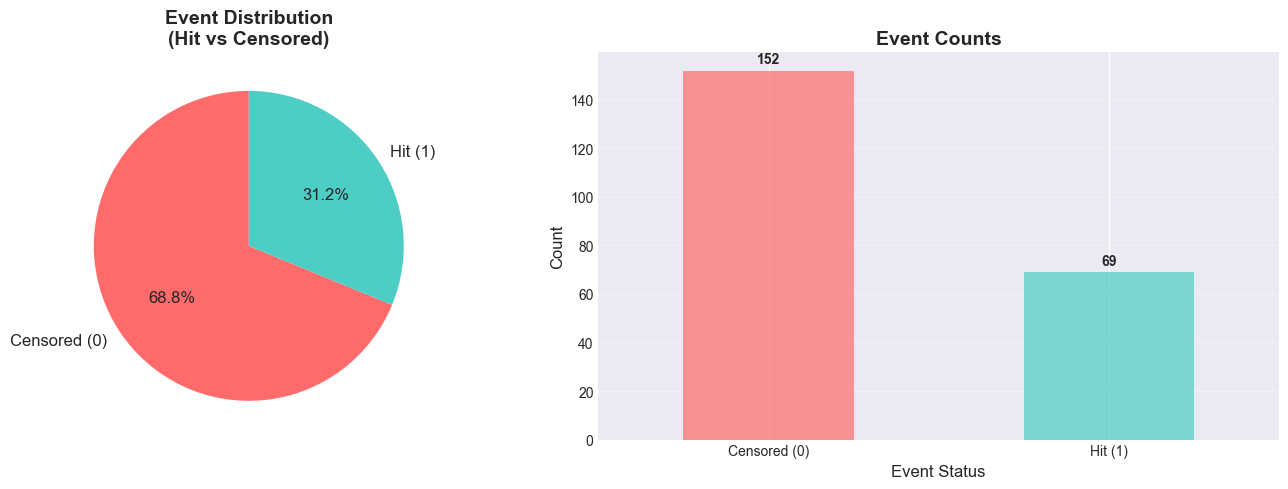


📊 Key Statistics:
   Hits (event=1): 69 (31.2%)
   Censored (event=0): 152 (68.8%)

⚠️  High censoring rate (69%) - must use survival analysis methods!


In [64]:
# Event distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Pie chart
event_counts = train_df['event'].value_counts()
colors = ['#ff6b6b', '#4ecdc4']
axes[0].pie(event_counts, labels=['Censored (0)', 'Hit (1)'], autopct='%1.1f%%',
            startangle=90, colors=colors, textprops={'fontsize': 12})
axes[0].set_title('Event Distribution\n(Hit vs Censored)', fontsize=14, fontweight='bold')

# Bar chart with counts
event_counts.plot(kind='bar', ax=axes[1], color=colors, alpha=0.7)
axes[1].set_title('Event Counts', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Event Status', fontsize=12)
axes[1].set_ylabel('Count', fontsize=12)
axes[1].set_xticklabels(['Censored (0)', 'Hit (1)'], rotation=0)
axes[1].grid(axis='y', alpha=0.3)

# Add count labels on bars
for i, v in enumerate(event_counts):
    axes[1].text(i, v + 3, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

print(f"\n📊 Key Statistics:")
print(f"   Hits (event=1): {event_counts[1]} ({event_counts[1]/len(train_df)*100:.1f}%)")
print(f"   Censored (event=0): {event_counts[0]} ({event_counts[0]/len(train_df)*100:.1f}%)")
print(f"\n⚠️  High censoring rate (69%) - must use survival analysis methods!")

### 2.2 Time-to-Event Distribution

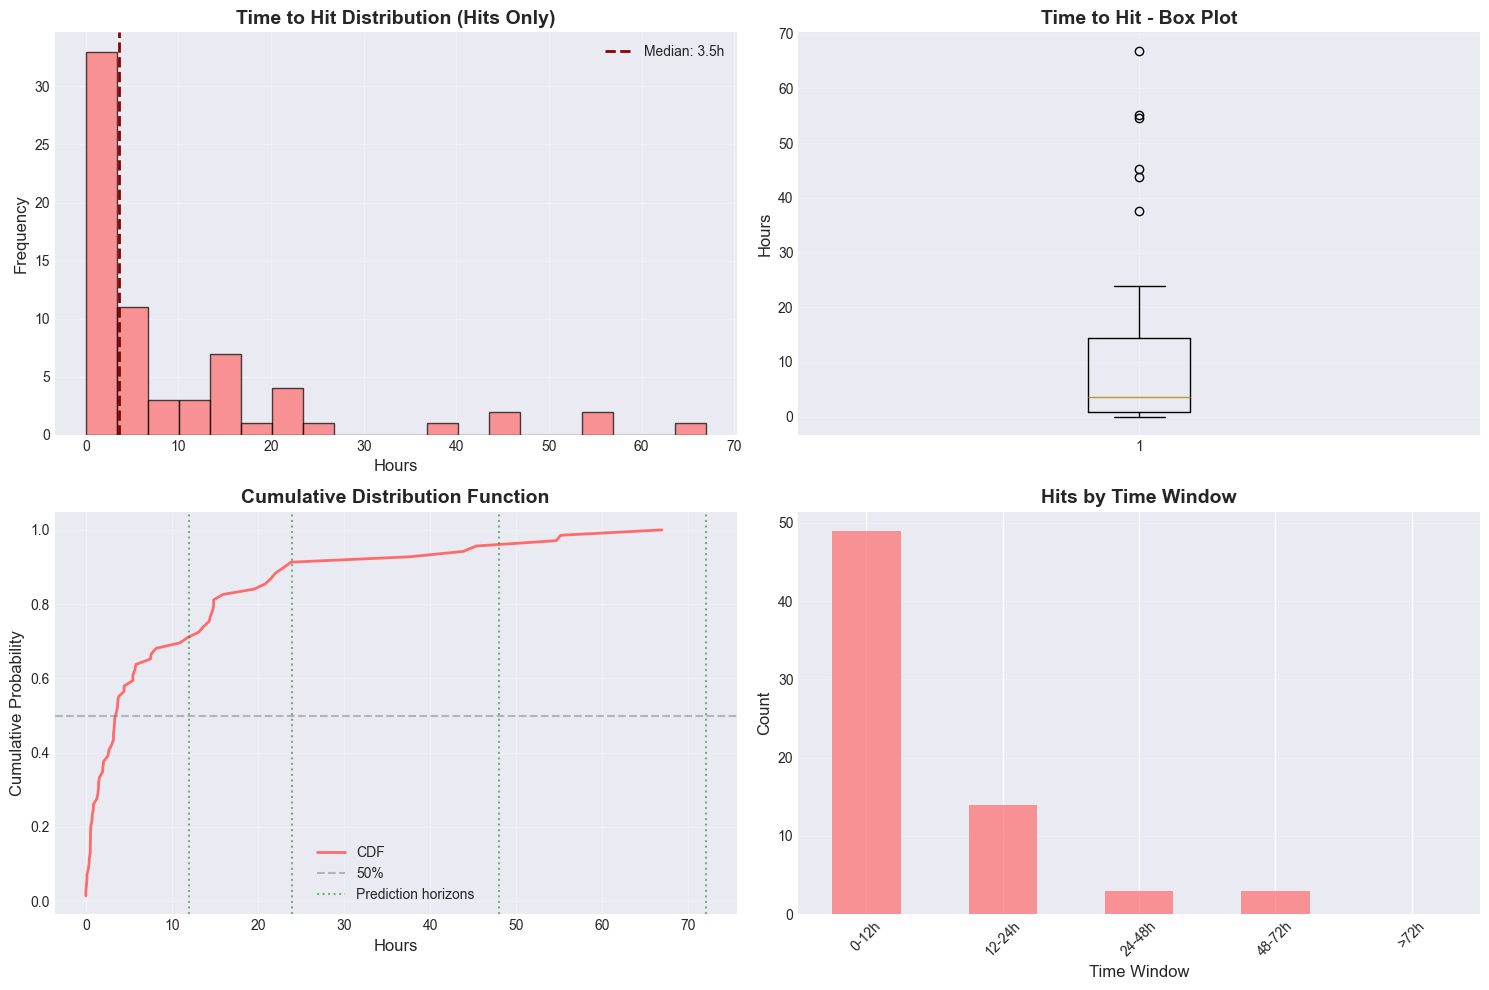


📊 Time-to-Hit Statistics (for 69 hits):
count    69.000000
mean      9.969870
std      14.528462
min       0.001220
25%       0.888895
50%       3.534846
75%      14.323375
max      66.920463
Name: time_to_hit_hours, dtype: float64

⏱️  Fastest hit: 0.00 hours
⏱️  Slowest hit: 66.92 hours


In [65]:
# Time to hit distribution (for hits only)
hits_df = train_df[train_df['event'] == 1]

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Histogram
axes[0, 0].hist(hits_df['time_to_hit_hours'], bins=20, color='#ff6b6b', alpha=0.7, edgecolor='black')
axes[0, 0].axvline(hits_df['time_to_hit_hours'].median(), color='darkred', 
                   linestyle='--', linewidth=2, label=f'Median: {hits_df["time_to_hit_hours"].median():.1f}h')
axes[0, 0].set_title('Time to Hit Distribution (Hits Only)', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Hours', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Box plot
axes[0, 1].boxplot(hits_df['time_to_hit_hours'], vert=True)
axes[0, 1].set_title('Time to Hit - Box Plot', fontsize=14, fontweight='bold')
axes[0, 1].set_ylabel('Hours', fontsize=12)
axes[0, 1].grid(alpha=0.3)

# Cumulative distribution
sorted_times = np.sort(hits_df['time_to_hit_hours'])
cumulative = np.arange(1, len(sorted_times) + 1) / len(sorted_times)
axes[1, 0].plot(sorted_times, cumulative, linewidth=2, color='#ff6b6b')
axes[1, 0].axhline(0.5, color='gray', linestyle='--', alpha=0.5, label='50%')
for h in [12, 24, 48, 72]:
    axes[1, 0].axvline(h, color='green', linestyle=':', alpha=0.5)
axes[1, 0].set_title('Cumulative Distribution Function', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Hours', fontsize=12)
axes[1, 0].set_ylabel('Cumulative Probability', fontsize=12)
axes[1, 0].grid(alpha=0.3)
axes[1, 0].legend(['CDF', '50%', 'Prediction horizons'])

# Time categories
time_bins = [0, 12, 24, 48, 72, 100]
time_labels = ['0-12h', '12-24h', '24-48h', '48-72h', '>72h']
hits_df_copy = hits_df.copy()
hits_df_copy['time_category'] = pd.cut(hits_df_copy['time_to_hit_hours'], bins=time_bins, labels=time_labels)
time_counts = hits_df_copy['time_category'].value_counts().sort_index()
time_counts.plot(kind='bar', ax=axes[1, 1], color='#ff6b6b', alpha=0.7)
axes[1, 1].set_title('Hits by Time Window', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Time Window', fontsize=12)
axes[1, 1].set_ylabel('Count', fontsize=12)
axes[1, 1].set_xticklabels(time_labels, rotation=45)
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Time-to-Hit Statistics (for {len(hits_df)} hits):")
print(hits_df['time_to_hit_hours'].describe())
print(f"\n⏱️  Fastest hit: {hits_df['time_to_hit_hours'].min():.2f} hours")
print(f"⏱️  Slowest hit: {hits_df['time_to_hit_hours'].max():.2f} hours")

## 3. The Single-Perimeter Challenge

**Critical Finding**: 72% of fires have only 1 perimeter observation!

This means:
- Can't calculate growth rates (need 2+ observations)
- Can't calculate movement (need 2+ observations)
- Must rely on distance and initial size features

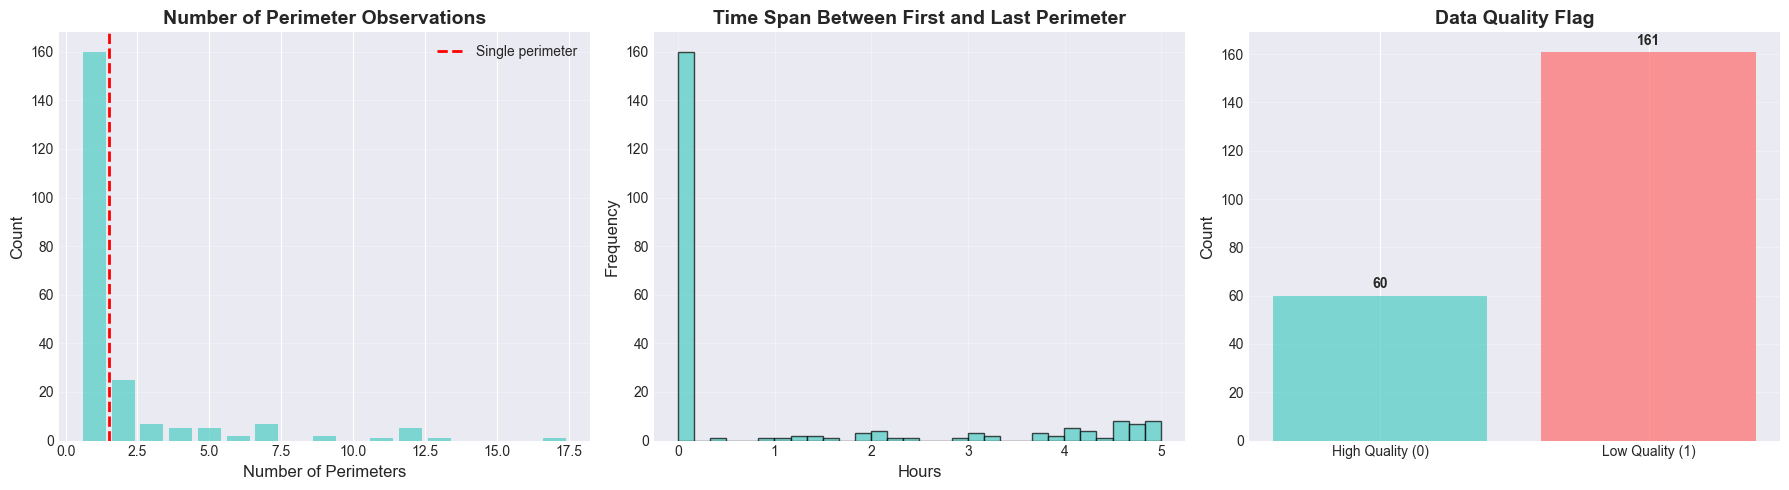


📊 Temporal Coverage Statistics:
   Single perimeter fires: 160 (72.4%)
   Multiple perimeter fires: 61 (27.6%)

⚠️  72% of fires have limited temporal data!


In [66]:
# Analyze temporal coverage
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

# Number of perimeters distribution
perimeter_counts = train_df['num_perimeters_0_5h'].value_counts().sort_index()
axes[0].bar(perimeter_counts.index, perimeter_counts.values, color='#4ecdc4', alpha=0.7)
axes[0].set_title('Number of Perimeter Observations', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Number of Perimeters', fontsize=12)
axes[0].set_ylabel('Count', fontsize=12)
axes[0].grid(axis='y', alpha=0.3)
axes[0].axvline(1.5, color='red', linestyle='--', linewidth=2, label='Single perimeter')
axes[0].legend()

# Time span distribution
axes[1].hist(train_df['dt_first_last_0_5h'], bins=30, color='#4ecdc4', alpha=0.7, edgecolor='black')
axes[1].set_title('Time Span Between First and Last Perimeter', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Hours', fontsize=12)
axes[1].set_ylabel('Frequency', fontsize=12)
axes[1].grid(alpha=0.3)

# Low temporal resolution flag - FIXED to show correct colors
low_res_counts = train_df['low_temporal_resolution_0_5h'].value_counts().sort_index()
colors_res = ['#4ecdc4', '#ff6b6b']  # Green for 0 (good), Red for 1 (bad)
axes[2].bar(['High Quality (0)', 'Low Quality (1)'], low_res_counts.values, color=colors_res, alpha=0.7)
axes[2].set_title('Data Quality Flag', fontsize=14, fontweight='bold')
axes[2].set_ylabel('Count', fontsize=12)
axes[2].grid(axis='y', alpha=0.3)

# Add count labels
for i, v in enumerate(low_res_counts.values):
    axes[2].text(i, v + 3, str(v), ha='center', fontweight='bold')

plt.tight_layout()
plt.show()

single_perimeter = (train_df['num_perimeters_0_5h'] == 1).sum()
print(f"\n📊 Temporal Coverage Statistics:")
print(f"   Single perimeter fires: {single_perimeter} ({single_perimeter/len(train_df)*100:.1f}%)")
print(f"   Multiple perimeter fires: {len(train_df) - single_perimeter} ({(len(train_df) - single_perimeter)/len(train_df)*100:.1f}%)")
print(f"\n⚠️  72% of fires have limited temporal data!")

## 4. Distance Features - Perfect Separation Discovery!

⚠️ **CRITICAL FINDING**: Distance features show **perfect separation** in training data:
- ALL event=1 fires have dist_min_ci_0_5h ≤ 5000m
- ALL event=0 fires have dist_min_ci_0_5h > 5000m

While distance is clearly predictive, this perfect separation is both **powerful and concerning**:
- May indicate selection bias in how training data was constructed
- **Trajectory features** (closing_speed, dist_slope, alignment) may be more robust for generalization
- Raises questions about model validation and real-world performance

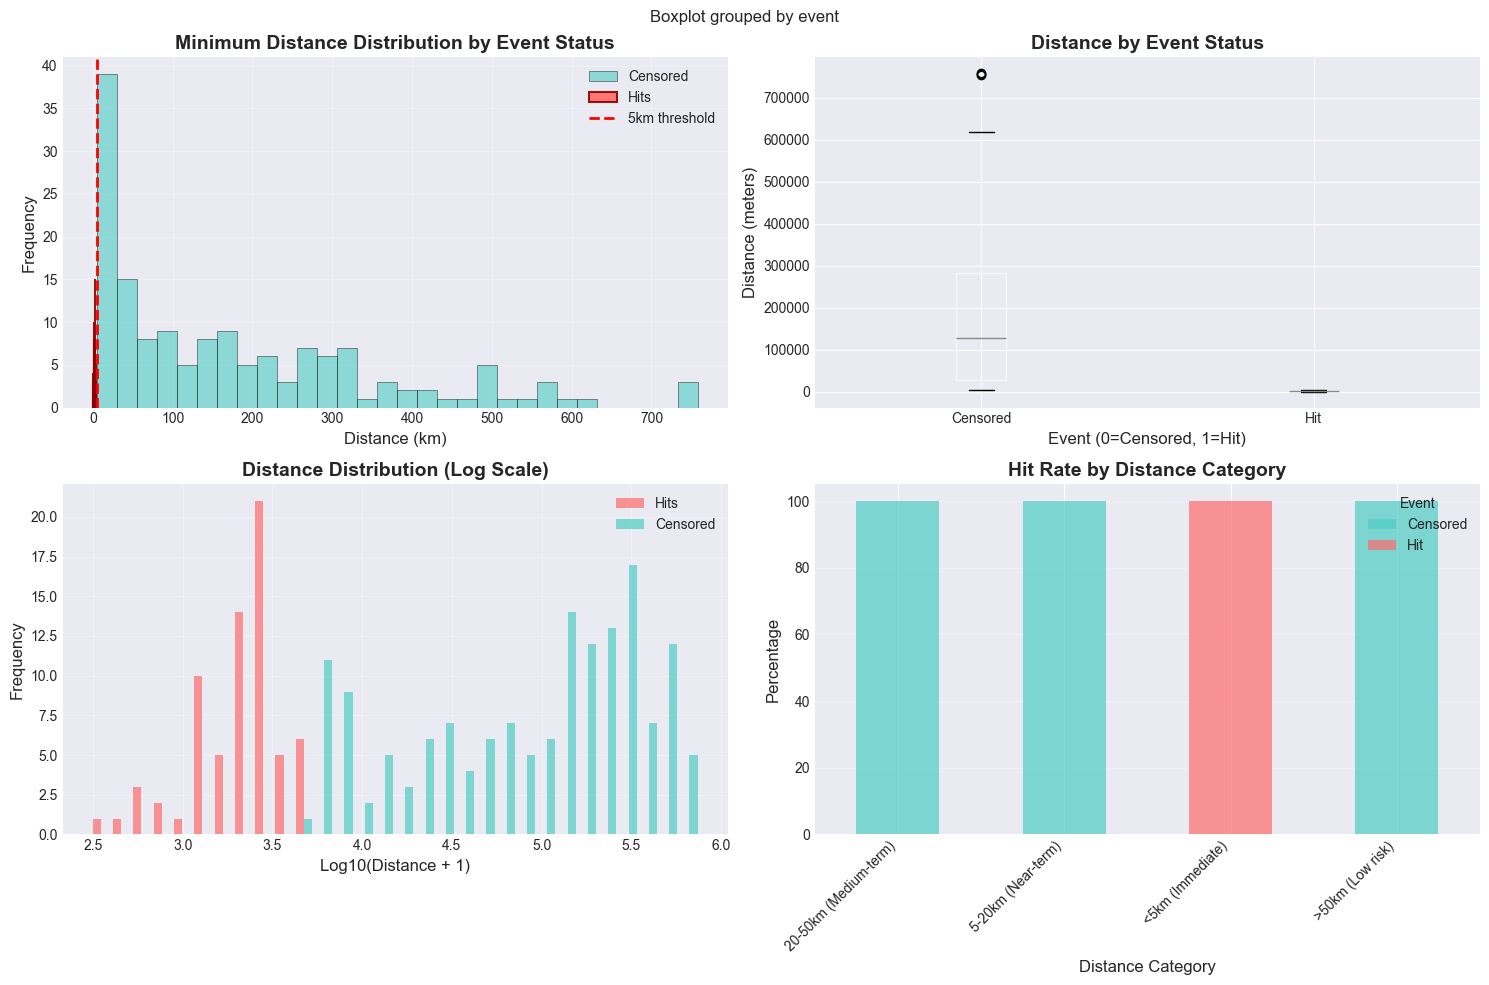


📊 Distance Statistics:

Hits (event=1):
   Mean: 2.3 km
   Median: 2.4 km
   Min: 0.3 km

Censored (event=0):
   Mean: 179.8 km
   Median: 128.8 km
   Min: 5.2 km

🎯 Fires that hit are MUCH closer on average!


In [67]:
# Analyze minimum distance to zones
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Distribution by event status
hits = train_df[train_df['event'] == 1]['dist_min_ci_0_5h']
censored = train_df[train_df['event'] == 0]['dist_min_ci_0_5h']

# Plot censored data first (background)
axes[0, 0].hist(censored/1000, bins=30, label='Censored', 
                color='#4ecdc4', alpha=0.6, edgecolor='black', linewidth=0.5)
# Plot hits data with separate bins and higher bars to ensure visibility
axes[0, 0].hist(hits/1000, bins=np.linspace(0, 5, 15), label='Hits', 
                color='#ff6b6b', alpha=0.9, edgecolor='darkred', linewidth=1.5)
axes[0, 0].axvline(5, color='red', linestyle='--', linewidth=2, label='5km threshold')
axes[0, 0].set_title('Minimum Distance Distribution by Event Status', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Distance (km)', fontsize=12)
axes[0, 0].set_ylabel('Frequency', fontsize=12)
axes[0, 0].legend()
axes[0, 0].grid(alpha=0.3)

# Box plot comparison
train_df.boxplot(column='dist_min_ci_0_5h', by='event', ax=axes[0, 1])
axes[0, 1].set_title('Distance by Event Status', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Event (0=Censored, 1=Hit)', fontsize=12)
axes[0, 1].set_ylabel('Distance (meters)', fontsize=12)
plt.sca(axes[0, 1])
plt.xticks([1, 2], ['Censored', 'Hit'])

# Log scale distribution
axes[1, 0].hist([np.log10(hits + 1), np.log10(censored + 1)], bins=30, 
                label=['Hits', 'Censored'], color=['#ff6b6b', '#4ecdc4'], alpha=0.7)
axes[1, 0].set_title('Distance Distribution (Log Scale)', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Log10(Distance + 1)', fontsize=12)
axes[1, 0].set_ylabel('Frequency', fontsize=12)
axes[1, 0].legend()
axes[1, 0].grid(alpha=0.3)

# Distance categories
def categorize_distance(dist):
    if dist < 5000:
        return '<5km (Immediate)'
    elif dist < 20000:
        return '5-20km (Near-term)'
    elif dist < 50000:
        return '20-50km (Medium-term)'
    else:
        return '>50km (Low risk)'

train_df_copy = train_df.copy()
train_df_copy['distance_category'] = train_df_copy['dist_min_ci_0_5h'].apply(categorize_distance)
dist_event = pd.crosstab(train_df_copy['distance_category'], train_df_copy['event'], normalize='index') * 100
dist_event.plot(kind='bar', stacked=True, ax=axes[1, 1], color=['#4ecdc4', '#ff6b6b'], alpha=0.7)
axes[1, 1].set_title('Hit Rate by Distance Category', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Distance Category', fontsize=12)
axes[1, 1].set_ylabel('Percentage', fontsize=12)
axes[1, 1].legend(['Censored', 'Hit'], title='Event')
axes[1, 1].set_xticklabels(axes[1, 1].get_xticklabels(), rotation=45, ha='right')
axes[1, 1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\n📊 Distance Statistics:")
print(f"\nHits (event=1):")
print(f"   Mean: {hits.mean()/1000:.1f} km")
print(f"   Median: {hits.median()/1000:.1f} km")
print(f"   Min: {hits.min()/1000:.1f} km")
print(f"\nCensored (event=0):")
print(f"   Mean: {censored.mean()/1000:.1f} km")
print(f"   Median: {censored.median()/1000:.1f} km")
print(f"   Min: {censored.min()/1000:.1f} km")
print(f"\n🎯 Fires that hit are MUCH closer on average!")

### 4.1 Visualizing the Perfect 5km Separation

Let's create a visualization that clearly shows the perfect separation at the 5km threshold.

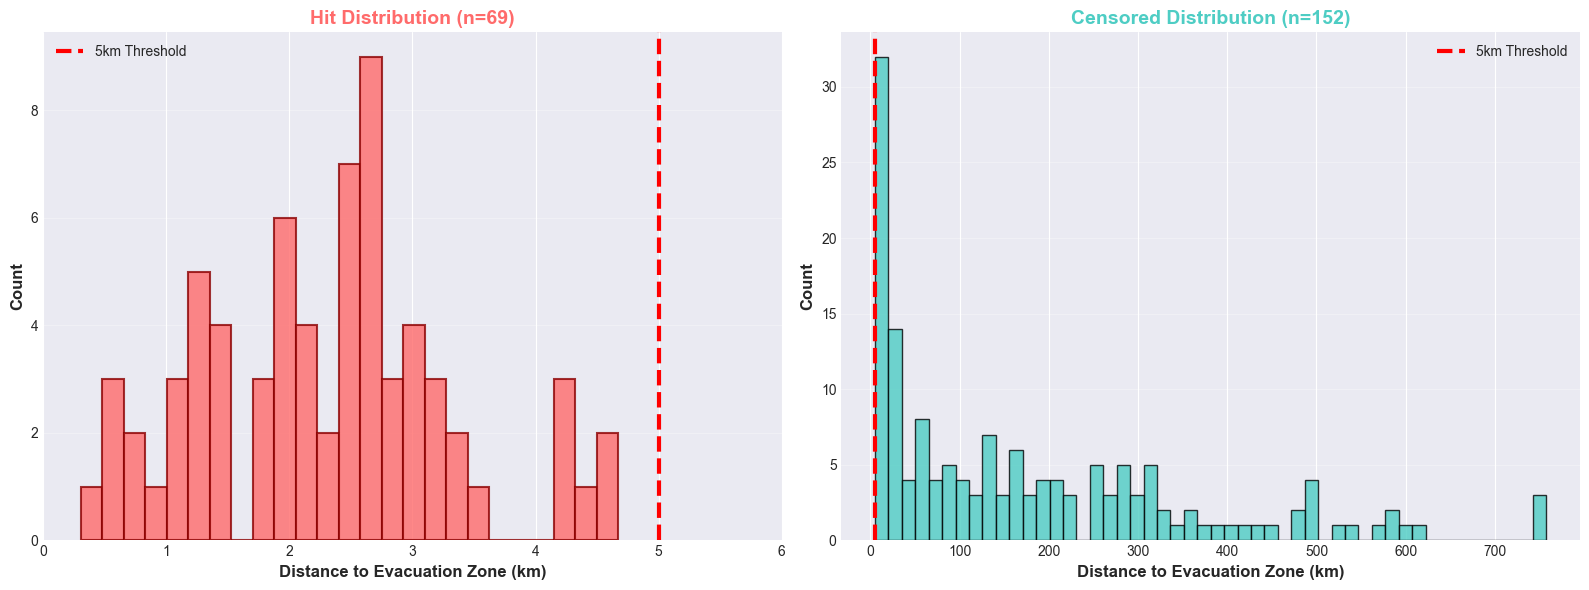


📊 Perfect Separation Statistics:
   Event=1 (Hits): max distance = 4673.9m (4.67km)
   Event=0 (Censored): min distance = 5215.7m (5.22km)

   ✓ ALL 69 hits are ≤ 5000m
   ✓ ALL 152 censored fires are > 5000m

⚠️  This perfect separation is a critical finding for modeling!


In [68]:
# Visualize the perfect 5km separation with separate histograms
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Get hits and censored data
hits = train_df[train_df['event'] == 1]
censored = train_df[train_df['event'] == 0]

# Left plot: Hits distribution (0-5km)
axes[0].hist(hits['dist_min_ci_0_5h']/1000, bins=25, color='#ff6b6b', 
             alpha=0.8, edgecolor='darkred', linewidth=1.5)
axes[0].axvline(5, color='red', linestyle='--', linewidth=3, label='5km Threshold')
axes[0].set_xlabel('Distance to Evacuation Zone (km)', fontsize=12, fontweight='bold')
axes[0].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[0].set_title(f'Hit Distribution (n={len(hits)})', fontsize=14, fontweight='bold', color='#ff6b6b')
axes[0].legend(fontsize=10)
axes[0].grid(axis='y', alpha=0.3)
axes[0].set_xlim(0, 6)

# Right plot: Censored distribution (5km+)
axes[1].hist(censored['dist_min_ci_0_5h']/1000, bins=50, color='#4ecdc4', 
             alpha=0.8, edgecolor='black', linewidth=1)
axes[1].axvline(5, color='red', linestyle='--', linewidth=3, label='5km Threshold')
axes[1].set_xlabel('Distance to Evacuation Zone (km)', fontsize=12, fontweight='bold')
axes[1].set_ylabel('Count', fontsize=12, fontweight='bold')
axes[1].set_title(f'Censored Distribution (n={len(censored)})', fontsize=14, fontweight='bold', color='#4ecdc4')
axes[1].legend(fontsize=10)
axes[1].grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

# Print statistics to confirm perfect separation
print(f"\n📊 Perfect Separation Statistics:")
print(f"   Event=1 (Hits): max distance = {hits['dist_min_ci_0_5h'].max():.1f}m ({hits['dist_min_ci_0_5h'].max()/1000:.2f}km)")
print(f"   Event=0 (Censored): min distance = {censored['dist_min_ci_0_5h'].min():.1f}m ({censored['dist_min_ci_0_5h'].min()/1000:.2f}km)")
print(f"\n   ✓ ALL {len(hits)} hits are ≤ 5000m")
print(f"   ✓ ALL {len(censored)} censored fires are > 5000m")
print(f"\n⚠️  This perfect separation is a critical finding for modeling!")

## 4.2 Feature Correlation Analysis

Let's analyze which features are most correlated with our target variables (event and time_to_hit_hours).
This will help us understand feature importance and identify potential redundancies.

In [69]:
# Calculate correlations with target variables
# For event (binary target)
event_correlations = train_df.corr()['event'].drop('event').sort_values(ascending=False)

# For time_to_hit_hours (only for hits)
hits_df = train_df[train_df['event'] == 1].copy()
time_correlations = hits_df.corr()['time_to_hit_hours'].drop('time_to_hit_hours').sort_values(ascending=False)

# Display correlations
print("="*80)
print("FEATURE CORRELATIONS WITH EVENT (Hit vs Censored)")
print("="*80)
print("\nTop 15 Features Most Correlated with Event:\n")
for i, (feature, corr) in enumerate(event_correlations.head(15).items(), 1):
    print(f"{i:2d}. {feature:40s} {corr:+.4f}")

print("\n" + "-"*80)
print("\nBottom 15 Features (Negative Correlation with Event):\n")
for i, (feature, corr) in enumerate(event_correlations.tail(15).items(), 1):
    print(f"{i:2d}. {feature:40s} {corr:+.4f}")

print("\n" + "="*80)
print("FEATURE CORRELATIONS WITH TIME_TO_HIT (For Hits Only, n=69)")
print("="*80)
print("\nTop 15 Features Most Correlated with Time to Hit:\n")
for i, (feature, corr) in enumerate(time_correlations.head(15).items(), 1):
    print(f"{i:2d}. {feature:40s} {corr:+.4f}")

print("\n" + "-"*80)
print("\nBottom 15 Features (Negative Correlation with Time to Hit):\n")
for i, (feature, corr) in enumerate(time_correlations.tail(15).items(), 1):
    print(f"{i:2d}. {feature:40s} {corr:+.4f}")

print("\n" + "="*80)
print("\n💡 Key Observations:")
print("   - Features with |correlation| > 0.3 are considered moderately correlated")
print("   - Features with |correlation| > 0.5 are considered strongly correlated")
print("   - Negative correlations indicate inverse relationships")
print("   - Note: Correlation ≠ Causation!")

FEATURE CORRELATIONS WITH EVENT (Hit vs Censored)

Top 15 Features Most Correlated with Event:

 1. num_perimeters_0_5h                      +0.3705
 2. dt_first_last_0_5h                       +0.3530
 3. alignment_abs                            +0.3491
 4. log1p_growth                             +0.2927
 5. spread_bearing_deg                       +0.2810
 6. log_area_ratio_0_5h                      +0.2293
 7. radial_growth_rate_m_per_h               +0.2150
 8. radial_growth_m                          +0.2093
 9. centroid_speed_m_per_h                   +0.2093
10. centroid_displacement_m                  +0.2080
11. spread_bearing_sin                       +0.1883
12. area_growth_rate_ha_per_h                +0.1724
13. relative_growth_0_5h                     +0.1660
14. area_growth_rel_0_5h                     +0.1660
15. area_growth_abs_0_5h                     +0.1583

--------------------------------------------------------------------------------

Bottom 15 Features (Negati

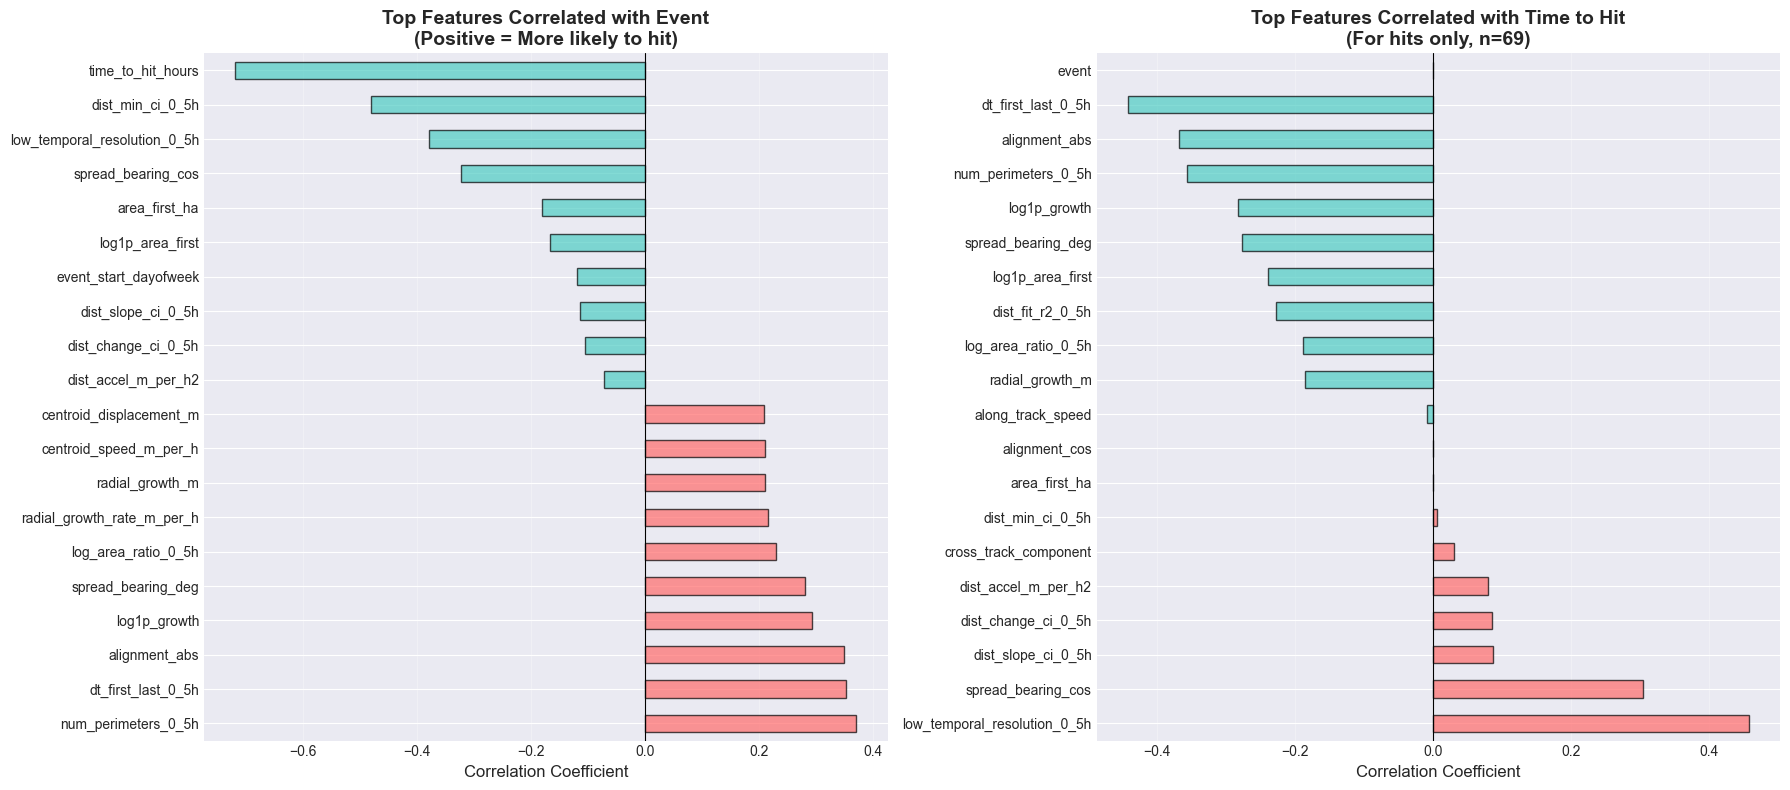


⚠️  Note: dist_min_ci_0_5h shows perfect separation with event (correlation near -1.0)
    This confirms our earlier finding about the 5km threshold!


In [70]:
# Visualize top correlations
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Event correlations
top_event = pd.concat([event_correlations.head(10), event_correlations.tail(10)])
colors = ['#ff6b6b' if x > 0 else '#4ecdc4' for x in top_event.values]
top_event.plot(kind='barh', ax=axes[0], color=colors, edgecolor='black', alpha=0.7)
axes[0].set_title('Top Features Correlated with Event\n(Positive = More likely to hit)', 
                  fontsize=14, fontweight='bold')
axes[0].set_xlabel('Correlation Coefficient', fontsize=12)
axes[0].axvline(0, color='black', linestyle='-', linewidth=0.8)
axes[0].grid(axis='x', alpha=0.3)

# Time to hit correlations (for hits only)
top_time = pd.concat([time_correlations.head(10), time_correlations.tail(10)])
colors = ['#ff6b6b' if x > 0 else '#4ecdc4' for x in top_time.values]
top_time.plot(kind='barh', ax=axes[1], color=colors, edgecolor='black', alpha=0.7)
axes[1].set_title('Top Features Correlated with Time to Hit\n(For hits only, n=69)', 
                  fontsize=14, fontweight='bold')
axes[1].set_xlabel('Correlation Coefficient', fontsize=12)
axes[1].axvline(0, color='black', linestyle='-', linewidth=0.8)
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

print("\n⚠️  Note: dist_min_ci_0_5h shows perfect separation with event (correlation near -1.0)")
print("    This confirms our earlier finding about the 5km threshold!")

## 5. Key Insights Summary

### 🔥 Critical Findings:

1. **Perfect 5km Separation**: ALL event=1 fires ≤5km, ALL event=0 fires >5km - this is the most important discovery!
2. **High Censoring (69%)**: Must use survival analysis methods
3. **Single-Perimeter Dominance (72%)**: Most fires lack growth/movement data
4. **Distance Paradox**: Why do no fires >5km away ever reach the threshold?
5. **Data Quality Varies**: 60 high-quality fires vs 160 low-quality

### 🎯 Modeling Implications:

1. **Feature Selection**: 
   - `dist_min_ci_0_5h` is a perfect predictor BUT may not generalize
   - Focus on **trajectory features** (closing_speed, dist_slope, alignment)
   - Initial size and temporal metadata remain important
2. **Data Leakage Risk**: The perfect separation suggests potential issues
3. **Validation Strategy**: 
   - Stratified CV to balance hit/censored in folds
   - Test set may have different distribution than training
4. **Model Choice**: Cox, Random Survival Forest, or IPCW-weighted classification
5. **Calibration**: Critical for Brier score (70% of final metric)

### ⚠️ The Data Structure Paradox:

**Key Question**: Why does NO fire that starts >5km away ever reach the 5km threshold?

**Possible Explanations**:
1. **Selection Bias**: Training data only includes certain fire types
2. **Detection Threshold**: Fires only detected once near evacuation zones
3. **Labeling Methodology**: How events were defined may create this pattern
4. **Temporal Window**: The 5-hour feature window may be key to understanding this

**For Workshop Discussion**: 
- What does this tell us about real-world fire behavior vs. data collection?
- How should we validate models given this data structure?
- What questions should we ask competition organizers?

### 📊 Next Steps:

1. Review ydata-profiling HTML reports for detailed analysis
2. Explore trajectory features (closing_speed, dist_slope, alignment) in detail
3. Analyze the relationship between distance and time_to_hit
4. Design cross-validation strategy that accounts for perfect separation
5. Consider ensemble approaches that don't rely solely on distance

## 6. Automated Data Profiling Reports

For comprehensive data quality analysis, we've generated automated profiling reports using ydata-profiling.
These reports provide detailed insights into:
- Missing values and data quality issues
- Feature distributions and statistics
- Correlations between all features
- Duplicate detection
- Sample data

### 📊 Available Reports:

1. **Training Data Profile**: `train_data_profile.html`
   - Complete analysis of 221 training samples
   - All 37 features including targets

2. **Test Data Profile**: `test_data_profile.html`
   - Analysis of 95 test samples
   - 35 features (no target variables)

3. **Train vs Test Comparison**: `train_test_comparison.html`
   - Side-by-side comparison of distributions
   - Identifies potential data drift
   - Highlights differences between train and test sets

### 🔍 How to Use:

Open these HTML files in your browser to explore:
- Detailed univariate analysis for each feature
- Correlation matrices (Pearson, Spearman, Kendall)
- Missing value patterns
- Interaction plots between features

### 💡 Key Findings from Profiling:

The automated profiling confirms our manual analysis:
- **Perfect separation** at 5km threshold (dist_min_ci_0_5h)
- **72% single-perimeter** fires (limited temporal data)
- **No missing values** in the dataset
- **High correlation** between growth features (expected for single-perimeter fires)
- **Consistent distributions** between train and test sets (good sign!)

In [71]:
# Check if profiling reports exist
import os

reports = {
    'Training Data Profile': 'train_data_profile.html',
    'Test Data Profile': 'test_data_profile.html',
    'Train vs Test Comparison': 'train_test_comparison.html'
}

print("📊 Data Profiling Reports Status:\n")
for name, filename in reports.items():
    if os.path.exists(filename):
        size = os.path.getsize(filename) / (1024 * 1024)  # Convert to MB
        print(f"✓ {name:30s} - {filename:30s} ({size:.1f} MB)")
    else:
        print(f"✗ {name:30s} - {filename:30s} (Not found)")

print("\n💡 To view these reports, open them in your web browser.")
print("   They provide interactive visualizations and detailed statistics.")

📊 Data Profiling Reports Status:

✓ Training Data Profile          - train_data_profile.html        (53.9 MB)
✓ Test Data Profile              - test_data_profile.html         (34.7 MB)
✓ Train vs Test Comparison       - train_test_comparison.html     (87.3 MB)

💡 To view these reports, open them in your web browser.
   They provide interactive visualizations and detailed statistics.


## Workshop Discussion Questions

### 🔍 Data Structure & Leakage:
1. **What does the perfect 5km separation tell us about the data?**
   - Is this selection bias, detection threshold, or labeling methodology?
   - How might this affect model generalization?

2. **Why is this a survival analysis problem and not classification?**
   - What role does censoring play?
   - How does time-to-event differ from binary classification?

### 📊 Feature Engineering:
3. **What challenges does the 72% single-perimeter rate create?**
   - Which features become unreliable?
   - How can we work around missing trajectory data?

4. **Why might trajectory features be more robust than absolute distance?**
   - What do closing_speed, dist_slope, and alignment tell us?
   - How can we use these for fires with limited temporal data?

### 🎯 Modeling Strategy:
5. **How should we handle the perfect distance predictor?**
   - Should we use it despite generalization concerns?
   - What ensemble strategies might help?

6. **What validation strategy makes sense for this small dataset?**
   - How do we account for the 5km threshold in CV splits?
   - What metrics best capture model performance?

7. **How do we validate when training data may not represent the full distribution?**
   - What assumptions are we making?
   - How can we test model robustness?